In [1]:
import random
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.applications.resnet50 import ResNet50
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
# Initialize
epochs = 100
learning_rate = 2e-5
batch_size = 8
img_dims =  (228,400,3)

In [3]:
X_train = np.load("benign_resized(228x400)/X_train-228x400.npy")
y_train = np.load("benign_resized(228x400)/y_train-228x400.npy")
X_test = np.load("benign_resized(228x400)/X_test-228x400.npy")
y_test = np.load("benign_resized(228x400)/y_test-228x400.npy")

In [4]:
y_train = to_categorical(y_train) 
y_test = to_categorical(y_test) 

In [5]:
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=img_dims)
output = restnet.layers[-1].output
output = Flatten()(output)
restnet = Model(restnet.input, output)
for layer in restnet.layers:
    layer.trainable = False
restnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 228, 400, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 234, 406, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 114, 200, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 114, 200, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [6]:
restnet.trainable = True
set_trainable = False
for layer in restnet.layers:
    if layer.name in ['conv5_block3_2_conv', 'conv5_block3_3_conv', 'conv5_block3_2_relu']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
layers = [(layer, layer.name, layer.trainable) for layer in restnet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_1,False
1,<tensorflow.python.keras.layers.convolutional....,conv1_pad,False
2,<tensorflow.python.keras.layers.convolutional....,conv1_conv,False
3,<tensorflow.python.keras.layers.normalization_...,conv1_bn,False
4,<tensorflow.python.keras.layers.core.Activatio...,conv1_relu,False
...,...,...,...
171,<tensorflow.python.keras.layers.convolutional....,conv5_block3_3_conv,True
172,<tensorflow.python.keras.layers.normalization_...,conv5_block3_3_bn,True
173,<tensorflow.python.keras.layers.merge.Add obje...,conv5_block3_add,True
174,<tensorflow.python.keras.layers.core.Activatio...,conv5_block3_out,True


In [7]:
model = Sequential()
inputShape = img_dims
chanDim = -1   
        
model.add(restnet)

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
        
model.add(Dense(4, activation='softmax'))


In [8]:
# compile the model
# lr_schedule = schedules.ExponentialDecay(
#     learning_rate,
#     decay_steps=100000,
#     decay_rate=0.96)
# optimizer = SGD(learning_rate=lr_schedule)

optimizer = RMSprop(lr=learning_rate)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 212992)            23587712  
_________________________________________________________________
dense (Dense)                (None, 512)               109052416 
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
Total params: 132,904,836
Trainable params: 112,732,676
Non-trainable params: 20,172,160
_________________________________

In [9]:
model.save("ben-model.h5")

In [10]:
# CHECKPOINT
checkpoint_path="checkpoints/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [11]:
datagen = ImageDataGenerator(zoom_range=0.3, rotation_range=50,
 width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
 horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

In [12]:
# train the model
H = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),epochs=epochs,verbose=1,validation_data=(X_test, y_test),steps_per_epoch=len(X_train)/batch_size, callbacks=callbacks_list)

Epoch 1/100
248/248 [==============================] - 39s 136ms/step - loss: 2.3938 - accuracy: 0.3574 - val_loss: 1.0348 - val_accuracy: 0.5464

Epoch 00001: val_accuracy improved from -inf to 0.54637, saving model to checkpoints\weights-improvement-01-0.55.hdf5
Epoch 2/100
248/248 [==============================] - 31s 125ms/step - loss: 1.3307 - accuracy: 0.4919 - val_loss: 1.1042 - val_accuracy: 0.5504

Epoch 00002: val_accuracy improved from 0.54637 to 0.55040, saving model to checkpoints\weights-improvement-02-0.55.hdf5
Epoch 3/100
248/248 [==============================] - 31s 125ms/step - loss: 1.1575 - accuracy: 0.5328 - val_loss: 1.0009 - val_accuracy: 0.5847

Epoch 00003: val_accuracy improved from 0.55040 to 0.58468, saving model to checkpoints\weights-improvement-03-0.58.hdf5
Epoch 4/100
248/248 [==============================] - 31s 124ms/step - loss: 1.0527 - accuracy: 0.5660 - val_loss: 0.8293 - val_accuracy: 0.6532

Epoch 00004: val_accuracy improved from 0.58468 to 0

248/248 [==============================] - 31s 127ms/step - loss: 0.4310 - accuracy: 0.8582 - val_loss: 0.8508 - val_accuracy: 0.8367

Epoch 00077: val_accuracy did not improve from 0.85484
Epoch 78/100
248/248 [==============================] - 31s 125ms/step - loss: 0.3580 - accuracy: 0.8661 - val_loss: 0.8814 - val_accuracy: 0.8286

Epoch 00078: val_accuracy did not improve from 0.85484
Epoch 79/100
248/248 [==============================] - 32s 127ms/step - loss: 0.3670 - accuracy: 0.8725 - val_loss: 0.9336 - val_accuracy: 0.8347

Epoch 00079: val_accuracy did not improve from 0.85484
Epoch 80/100
248/248 [==============================] - 31s 127ms/step - loss: 0.4136 - accuracy: 0.8615 - val_loss: 1.0297 - val_accuracy: 0.8185

Epoch 00080: val_accuracy did not improve from 0.85484
Epoch 81/100
248/248 [==============================] - 31s 126ms/step - loss: 0.4369 - accuracy: 0.8587 - val_loss: 0.8443 - val_accuracy: 0.8347

Epoch 00081: val_accuracy did not improve from 0.8548

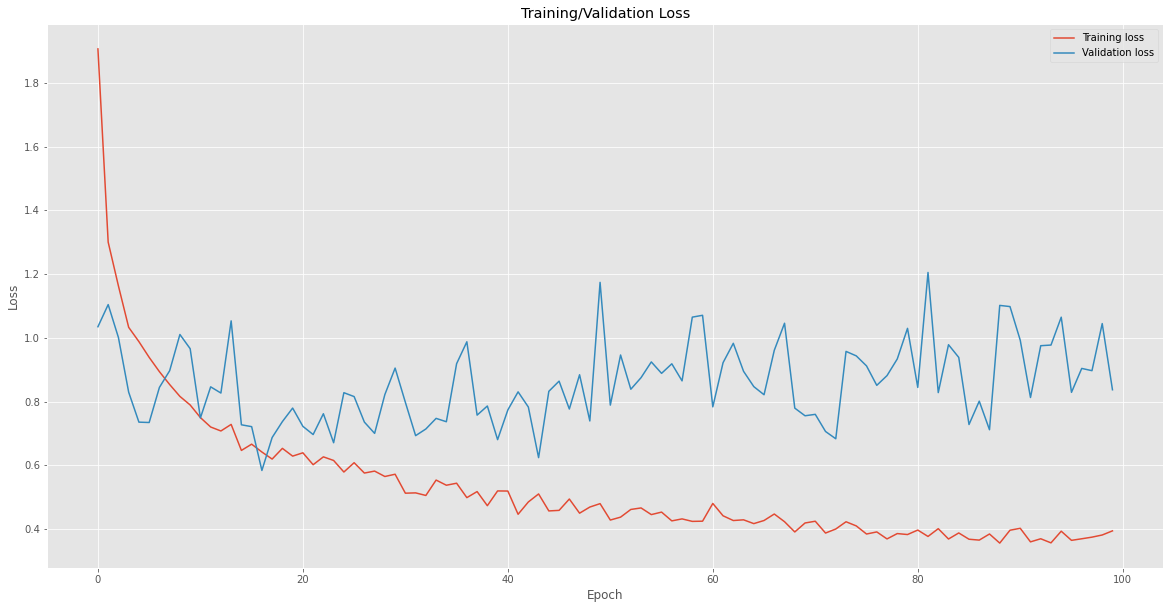

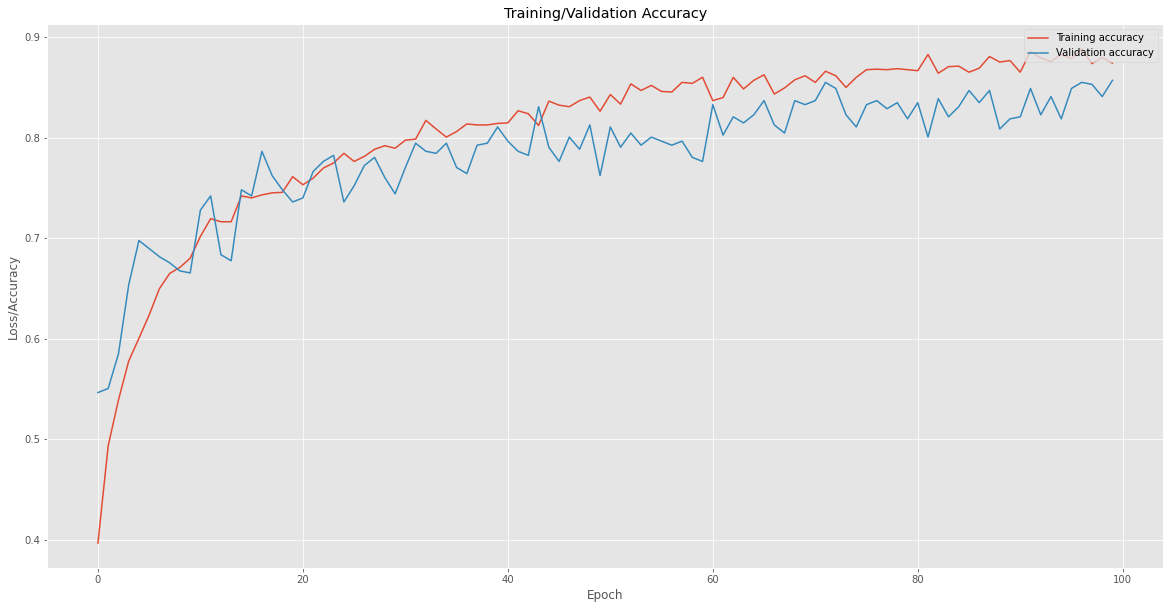

In [13]:
# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
N = epochs
plt.plot(np.arange(0,N), H.history["loss"], label="Training loss")
plt.plot(np.arange(0,N), H.history["val_loss"], label="Validation loss")
plt.title("Training/Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig("checkpoints/loss.png")
plt.show()


plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(np.arange(0,N), H.history["accuracy"], label="Training accuracy")
plt.plot(np.arange(0,N), H.history["val_accuracy"], label="Validation accuracy")
plt.title("Training/Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.savefig("checkpoints/accuracy.png")
plt.show()